In [2]:
%load_ext autoreload 
%autoreload 2

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import PIL

import nibabel

Start with figuring out how to create a snapshot of an image at a desired time. Need to: 

1. Open T1-reference image and imshow the desired slice.
2. Open concentration-data and imshow the desired slice on top of the previous image.
3. Save image into path

# Preliminary Tests

In [9]:
patpath = Path("DATA/PAT_002")
impath = patpath / "IMAGES"
simpath = patpath / "SIMULATION"
refpath = patpath / "mri/T1.mgz"

ref = nibabel.load(refpath)
mask = nibabel.load(patpath / "mri/parenchyma_only.mgz").get_fdata()
mask[mask==0] = np.nan

h = "51"
slice_idx = 101
data = nibabel.load(simpath / f"0{h}.nii.gz")
sim_diffusion = nibabel.load(simpath / f"diffusion_{h}.nii.gz")
sim_multidiff = nibabel.load(simpath / f"multidiffusion_total_{h}.nii.gz")
im_ref = ref.get_fdata()[:, slice_idx, :]


difference = sim_diffusion.get_fdata()[:, slice_idx, :] - sim_multidiff.get_fdata()[:, slice_idx, :]
vabs = max(abs(difference.min()), abs(difference.max()))
vabs = 0.2
plt.figure()
plt.imshow(im_ref.T, cmap="gray", origin="lower")
plt.imshow(difference.T, cmap="seismic", vmin=-vabs, vmax=+vabs, origin="lower", alpha=0.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(left=-0.1, right=1.1, top=1., bottom=0.)
plt.savefig("test.png", bbox_inches="tight")

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
for ax, nii in zip(axs, [data, sim_diffusion, sim_multidiff]):
    im = nii.get_fdata()[:, slice_idx, :].copy() * mask[:, slice_idx, :]
    ax.imshow(im_ref.T, cmap="gray", origin="lower")
    ax.imshow(im.T, cmap="jet", vmin=0.0, vmax=0.3, origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)

plt.show()

# Model Comparison

In [84]:
mask = nibabel.load(patpath / "mri/parenchyma_only.mgz").get_fdata()
mask[mask==0] = np.nan

def load_mri_data(fpath, slice_, mask=None):
    mri = nibabel.load(fpath)
    im = mri.get_fdata()[slice_]
    if mask is not None:
        im *= mask[slice_]
    return im 

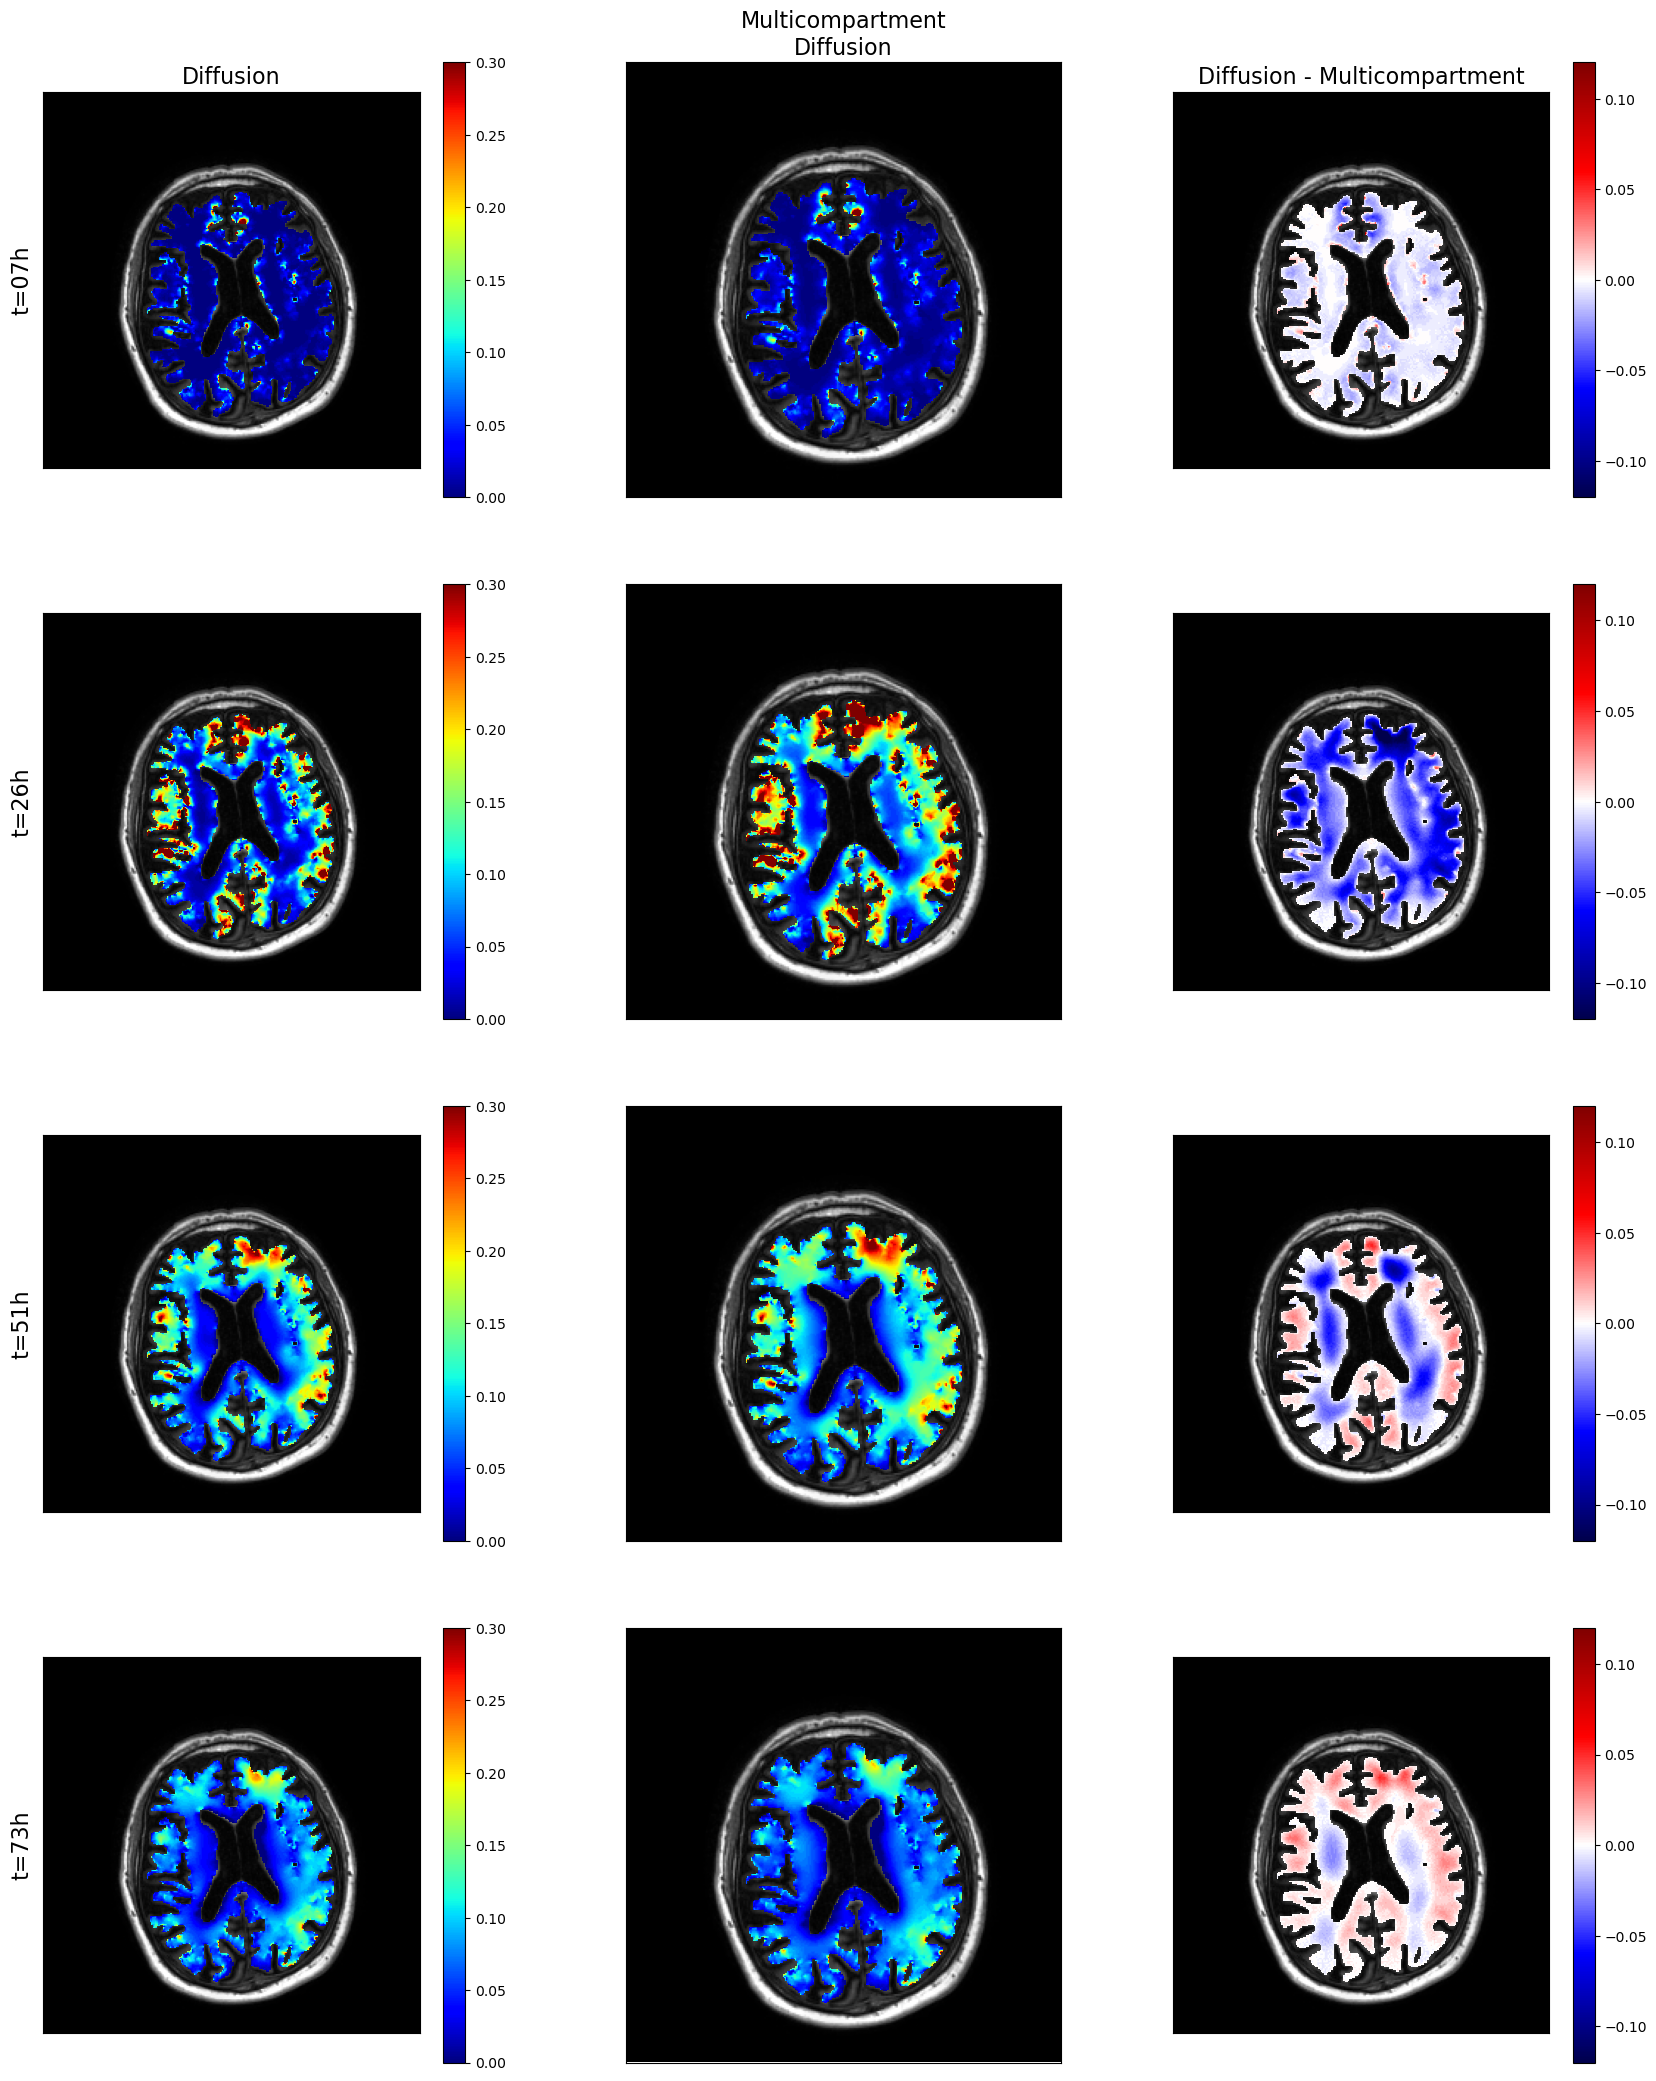

In [85]:
fig, axes = plt.subplots(4, 3, figsize=(16, 20))
slice_ = np.s_[:, 100, :]

titles = ["Diffusion", "Multicompartment\nDiffusion", "Diffusion - Multicompartment"]
for ax, title in zip(axes[0], titles):
    ax.set_title(title, fontsize=16)
    
hours = ["07", "26", "51", "73"]
for ax, hour in zip(axes[:, 0], hours):
    ax.set_ylabel(f"t={hour}h", fontsize=16)

for row, h in enumerate(hours):
    data = load_mri_data(simpath / f"0{h}.nii.gz", slice_, mask)
    im_diffusion = load_mri_data(simpath / f"diffusion_{h}.nii.gz", slice_, mask)
    im_multidiff = load_mri_data(simpath / f"multidiffusion_total_{h}.nii.gz", slice_, mask)
    difference = im_diffusion - im_multidiff
    ref = load_mri_data(patpath / "mri/T1.mgz", slice_, None)
    
    ax = axes[row, 0]
    ax.imshow(im_ref.T, cmap="gray", origin="lower")
    c = ax.imshow(im_diffusion.T, cmap="jet", vmin=0.0, vmax=0.3, origin="lower")
    plt.colorbar(c)
    
    ax = axes[row, 1]
    ax.imshow(im_ref.T, cmap="gray", origin="lower")
    c = ax.imshow(im_multidiff.T, cmap="jet", vmin=0.0, vmax=0.3, origin="lower")
#     plt.colorbar(c)
    
    diffmax = 0.12
    ax = axes[row, 2]
    ax.imshow(im_ref.T, cmap="gray", origin="lower")
    c = ax.imshow(difference.T, cmap="seismic", vmin=-diffmax, vmax=diffmax, origin="lower")
    plt.colorbar(c)
    
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
plt.savefig(f"model-comparison.png", bbox_inches="tight")
plt.show()

# Content Curves

Here the goal is to plot the total mass content in the brain and various brain regions at each of the time-points of the simulation, and compare this curve for different models.

I want to see at least four curves. 
- the total mass as computed from the diffusion model.
- the total mass as computed from the multicompartment-diffusion model.
- the mass within each of the compartments from the multidiffusion-model (two curves).

In [86]:
from pantarei.fenicsstorage import FenicsStorage
from 

In [92]:
import dolfin as df
from tqdm import tqdm

In [95]:
phi = [0.14, 0.05]

In [97]:
datapath = Path("DATA/PAT_002/FENICS/cdata_32.hdf")
storage = FenicsStorage(datapath, "r")

tvec = storage.read_timevector("diffusion")
mass_diffusion = np.nan * np.zeros(tvec.size)
mass_ecs = np.nan * np.zeros(tvec.size)
mass_pvs = np.nan * np.zeros(tvec.size)

domain = storage.read_domain()
for idx, ti in tqdm(enumerate(tvec)):
    u = storage.read_function("diffusion", domain, idx)
    mass_diffusion[idx] = df.assemble(u * df.dx)
    
    c = storage.read_function("multidiffusion", domain, idx)
    mass_ecs[idx] = phi[0] * df.assemble(c.sub(0) * df.dx)
    mass_pvs[idx] = phi[1] * df.assemble(c.sub(1) * df.dx)

74it [04:32,  3.68s/it]


In [104]:
t_data = storage.read_timevector("cdata")
mass_data = np.nan * np.zeros(t_data.size)
for idx, ti in enumerate(t_data):
    data = storage.read_function("cdata", domain, idx)
    mass_data[idx] = df.assemble(data * df.dx)
# storage.close()

In [109]:
mass_total = mass_ecs + mass_pvs

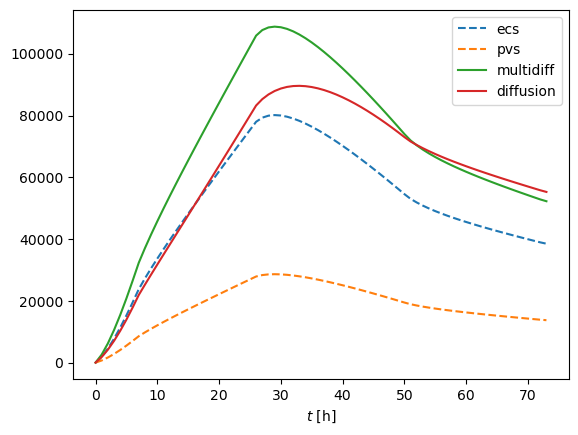

In [134]:
plt.figure()
plt.plot(tvec, mass_ecs, '--', label="ecs")
plt.plot(tvec, mass_pvs, '--', label="pvs")
plt.plot(tvec, mass_total, label='multidiff')
plt.plot(tvec, mass_diffusion, label="diffusion")
# plt.plot(t_data, mass_data, "o-k", label="data")
plt.xticks(tvec[::10], (tvec[::10] / 3600).astype(int))
plt.xlabel(r"$t$ [h]")
# for ti in t_data:
#     plt.axvline(ti, color="k", ls="--")
plt.legend()
plt.savefig("concentration-curves.png", bbox_inches='tight')
plt.show()